# Processamento de Linguagem Natural - Instituto Metrópole Digital 
### Etapa 1 - Análise de Sentimento do Twitter dos presidenciáveis de 2023 

- Docente:
    - Dr. Elias Jacob de Menezes Neto
- Discentes:
    - Igor Michael Araujo de Macedo
    - Keven Alison dos Santos Bezerra
    - Larissa Kelmer de Menezes Silva
    - Vinícius Soares Fernandes

Este notebook tem como objetivo o desenvolvimento da avaliação 1 da displina IMD1107 - Processamento de Linguagem Natural, cujo estudo se baseia na coleta e tratamento de dados de um data set PLN, realizando as principais etapas de limpeza de dados.

A ideia em torno dos dados escolhidos para este projeto se baseia em observar o comportamento dos principais candidatos à Presidência do Brasil, Lula e Bolsonaro, através do conteúdo postado em suas respectivas páginas do twitter.

## Sumário

1. [Configurações Iniciais](#config-inic)
2. [Pré-processamento](#preprocessamento)


## Configurações Iniciais

Inicialmente foi realizada a configuração geral do nosso ambiente de trabalho, realizando a importação dos dados e bibliotecas necessárias para sua devida execução no contexto do tema e da área de PLN.

### Configurações Gerais

Inclui a instalação de pacotes, importação de bibliotecas, download de recursos.

In [2]:
import os
# Detect if we are using Google Colab
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')

In [3]:
# Instalação dos pacotes necessários

!pip install -qq transformers
!pip install unidecode
!pip install enelvo
!pip install wordcloud
!python -m spacy download pt_core_news_sm
#!pip install --upgrade spacy
!pip install -r requirements.txt
!pip install aiohttp_socks
!pip install fake_useragent
!pip install googletransx

#! git clone https://bitbucket.org/HBrum/tweetsentbr.git ----> get emojis sentiments

     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
     -- ------------------------------------- 0.7/13.0 MB 14.2 MB/s eta 0:00:01
     ---- ----------------------------------- 1.6/13.0 MB 16.8 MB/s eta 0:00:01
     ------- -------------------------------- 2.4/13.0 MB 19.3 MB/s eta 0:00:01
     ---------- ----------------------------- 3.4/13.0 MB 19.5 MB/s eta 0:00:01
     ----------- ---------------------------- 3.9/13.0 MB 19.1 MB/s eta 0:00:01
     ------------- -------------------------- 4.5/13.0 MB 16.8 MB/s eta 0:00:01
     ---------------- ----------------------- 5.3/13.0 MB 16.8 MB/s eta 0:00:01
     ------------------- -------------------- 6.4/13.0 MB 17.9 MB/s eta 0:00:01
     ---------------------- ----------------- 7.4/13.0 MB 18.2 MB/s eta 0:00:01
     ------------------------- -------------- 8.4/13.0 MB 18.5 MB/s eta 0:00:01
     ---------------------------- ----------- 9.3/13.0 MB 18.5 MB/s eta 0:00:01
     ------------------------------- ------- 10.

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\larissa.silva\AppData\Local\Temp\pip-install-k7d5tava\cffi_2207edc95b7241b594fb3c24b52757de\setup.py", line 127, in <module>
          if sys.platform == 'win32' and uses_msvc():
        File "C:\Users\larissa.silva\AppData\Local\Temp\pip-install-k7d5tava\cffi_2207edc95b7241b594fb3c24b52757de\setup.py", line 105, in uses_msvc
          return config.try_compile('#ifndef _MSC_VER\n#error "not MSVC"\n#endif')
        File "C:\Users\larissa.silva\AppData\Local\miniconda3\envs\vm\lib\site-packages\setuptools\_distutils\command\config.py", line 220, in try_compile
          self._compile(body, headers, include_dirs, lang)
        File "C:\Users\larissa.silva\AppData\Local\miniconda3\env

In [29]:
# Importação das bibliotecas necessárias

%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import unidecode
import re
import os
from string import punctuation
from enelvo.normaliser import Normaliser
from nltk import ngrams
import nltk
from nltk import tokenize
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import statistics
import string
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [280]:
nlp = spacy.load('pt_core_news_sm')
nltk.download('stopwords')
nltk.download('punkt')
#nltk.download('all')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\larissa.silva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\larissa.silva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [236]:
pd.set_option('display.max_colwidth', None)

### Configurações da API e Requisição de Dados

A fim de criar um dataset que atenda aos propósitos deste trabalho, a análise de sentimento de tuítes, 
fez-se uso de uma ferramenta na linguagem Python, a [Optimized-Modified-GetOldTweets3 (OMGOT)](https://github.com/marquisvictor/Optimized-Modified-GetOldTweets3-OMGOT/tree/master), baseada 
na própria [Application Programming Interface (API)](https://developer.twitter.com/en/docs/twitter-api), ou Interface de Programação de Aplicação, do Twitter. 
O diferencial dessa plataform ́e a não necessidade de se ter uma conta na plataforma, a quantidade de tuítes 
retornados na busca - a API do Twitter se limita a 500 por mês, e a possibilidade de que buscas mais 
extensas sejam feitas em contas de usuários terceiros. Por ser a OMGOT  ́e uma ferramenta derivada da 
API do Twitter, o retorno da sua busca mantém os mesmos parâmetros das reornadas pela outra ferramenta.

> Observação: Apesar de retornar grandes volumes de dados, a OMGOT não exclui a possibilidade de não ter 
conseguido devolver todos os tuítes buscados.



##### Fomato para requisição da API
> ! python cli.py --username <user> --until/since <ano-mês-dia> -o <nome_arquivo.extensão> --csv <extensão>

In [6]:
os.chdir(r'.\pln\projeto_etapa1')

print(os.getcwd())

# Clone the entire repo
!git clone -b fix-api https://github.com/marquisvictor/Optimized-Modified-GetOldTweets3-OMGOT.git

C:\Users\larissa.silva\Documents\pessoal\UFRN\2024.1\pln\projeto_etapa1


Cloning into 'Optimized-Modified-GetOldTweets3-OMGOT'...


In [38]:
os.chdir('Optimized-Modified-GetOldTweets3-OMGOT')
os.chdir('GetOldTweets3-0.0.10')
os.chdir('..')

print(os.getcwd())

C:\Users\larissa.silva\Documents\pessoal\UFRN\2024.1\pln\projeto_etapa1


#### Importação do DataFrame com dados de cada candidato

> Inclui a seleção de features do DF, para incluir apenas o nome do candidato e o texto dos tuítes

#### Lula

In [ ]:
#!python cli.py --username "LulaOficial" --until "2018-04-07" -o lula1.csv --csv
#!python cli.py --username "LulaOficial" --since "2024-04-01" -o lula2.csv --csv
#lula1 = pd.read_csv('/content/drive/MyDrive/UFRN/2024/2024.1/pln/projeto_etapa1/lulaxboroliro/lula1.csv')
#lula2 = pd.read_csv('/content/drive/MyDrive/UFRN/2024/2024.1/pln/projeto_etapa1/lulaxboroliro/lula2.csv')
#lula_df = pd.concat([lula1, lula2])
#lula_df = lula_df.sort_values(by=['created_at'], ascending=False)

In [40]:
lula_df = pd.read_csv('.\data\lula_df.csv')
lula_df = lula_df.reset_index(drop=True)
lula_df.head()

,date,time,name,tweet,replies_count,retweets_count,likes_count
0,2022-08-08,20:33:10,Lula,O Brasil piorou. A nova pesquisa do boletim De...,299,394,2383
1,2022-08-08,18:07:24,Lula,Nós estamos disputando com alguém que prometeu...,1369,845,6106
2,2022-08-08,14:42:08,Lula,As mentiras contra Lula já aconteciam antes me...,705,998,4201
3,2022-08-08,10:32:04,Lula,Aprendi com minha mãe a não desistir. Quando v...,3645,1750,16921
4,2022-08-07,21:50:14,Lula,"""Um dos meus sonhos é um dia estudar medicina....",1252,860,5902


In [41]:
print(f'Formato DF Lula: {np.shape(lula_df)}')

Formato DF Lula: (15140, 7)


In [42]:
print('Informações DF Lula:\n')

print(lula_df.info())

Informações DF Lula:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15140 entries, 0 to 15139
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            15140 non-null  object
 1   time            15140 non-null  object
 2   name            15140 non-null  object
 3   tweet           15140 non-null  object
 4   replies_count   15140 non-null  int64 
 5   retweets_count  15140 non-null  int64 
 6   likes_count     15140 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 828.1+ KB
None


In [ ]:
print(lula_df.isna().any())

date              False
time              False
name              False
tweet             False
replies_count     False
retweets_count    False
likes_count       False
dtype: bool


In [ ]:
lula_df.drop(['replies_count', 'retweets_count', 'likes_count', 'time', 'date'], axis=1, inplace=True)

In [ ]:
lula_df.drop_duplicates(['tweet'], inplace = True)

In [ ]:
lula_df.to_csv(".\data\lula_df.csv", index=False)

#### Bolsonaro

In [ ]:
#!python cli.py --username "jairbolsonaro" -o bolsonaro.csv --csv

In [44]:
bolsonaro_df = pd.read_csv(r'.\data\bolsonaro_df.csv')

In [45]:
bolsonaro_df.head()

,date,time,name,tweet,replies_count,retweets_count,likes_count
0,2022-08-08,20:26:17,Jair M. Bolsonaro,"Acompanhe, no horário, ao vivo, pelo Canal do ...",587,2966,14734
1,2022-08-08,16:29:03,Jair M. Bolsonaro,- Entre os planos aplicados pela atual gestão ...,123,1523,10129
2,2022-08-08,16:29:03,Jair M. Bolsonaro,- Recentemente priorizando o saneamento básico...,113,1785,11423
3,2022-08-08,16:29:02,Jair M. Bolsonaro,"- Longe do PT, BNDES que patrocinava obras em...",937,5075,23381
4,2022-08-08,09:35:36,Jair M. Bolsonaro,"- Também, a ampliação do Teto do financiamento...",183,2154,12326


In [47]:
print(f'Formato DF Bolsonaro: {np.shape(bolsonaro_df)}')

Formato DF Bolsonaro: (12540, 7)


In [48]:
print('Informações DF Bolsonaro:\n')

print(bolsonaro_df.info())

Informações DF Bolsonaro:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12540 entries, 0 to 12539
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            12540 non-null  object
 1   time            12540 non-null  object
 2   name            12540 non-null  object
 3   tweet           12540 non-null  object
 4   replies_count   12540 non-null  int64 
 5   retweets_count  12540 non-null  int64 
 6   likes_count     12540 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 685.9+ KB
None


In [49]:
print(bolsonaro_df.isna().any())

date              False
time              False
name              False
tweet             False
replies_count     False
retweets_count    False
likes_count       False
dtype: bool


In [50]:
bolsonaro_df.drop_duplicates(['tweet'], inplace = True)

In [51]:
bolsonaro_df.drop(['replies_count', 'retweets_count', 'likes_count', 'time', 'date'], axis=1, inplace=True)

In [ ]:
bolsonaro_df.to_csv(r'.\data\bolsonaro_df.csv', index = False)

## Pré-processamento

In [85]:
lula_df = pd.read_csv(r'.\data\lula_df.csv', encoding='utf-8')
bolsonaro_df = pd.read_csv(r'.\data\bolsonaro_df.csv', encoding='utf-8')

### Padronização

Uma vez que o conjunto de dados é pequeno, desbalanceamentos (pequenos) têm maior relevância do que
para um conjunto grande de dados. Dessa forma, optou-se por manter a mesma quantidade de dados para
cada um dos candidatos.

In [7]:
lula_df.tweet.count()

15140

In [8]:
bolsonaro_df.tweet.count()

12540

In [119]:
lula_df = lula_df[:12540]

In [120]:
lula_df.tweet.count()

12540

### Visualização Prévia

Essa seção é uma demonstração da necessidade de limpeza dos dados antes de se poder obter epifanias sobre eles, além de definir funções que poderão, mais tarde, ser usadas para visualização gráfica dos dados.

In [86]:
def generate_wordcloud_from_df_column(df, column_name, nome):
    # Concatena todos os textos da coluna em uma única string
    text = ' '.join(df[column_name].astype(str).tolist())
    
    word_freq = Counter(text.split())
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras de '+nome+'\n')
    plt.show()

In [87]:
def graf_pareto(texto, coluna_texto, quantidade, nome):
  todas_palavras = ' '.join([resenha for resenha in texto[coluna_texto]])
  token_frase = nltk.tokenize.WhitespaceTokenizer().tokenize(todas_palavras)
  frequencias = nltk.FreqDist(token_frase)
  df_frequencias = pd.DataFrame({'Palavras': frequencias.keys(),
                               'Frequencia': frequencias.values()})

  df_frequencias = df_frequencias.nlargest(n=quantidade, columns='Frequencia')

  total = df_frequencias['Frequencia'].sum()
  df_frequencias['Porcentagem'] = (df_frequencias['Frequencia'].cumsum() / total) * 100

  plt.figure(figsize = (12,8))
  ax = sns.barplot(data = df_frequencias, x = 'Palavras', y = 'Frequencia', color = 'lightblue')
  ax2 = ax.twinx()
  sns.lineplot(data = df_frequencias, x = 'Palavras', y = 'Porcentagem', color = 'red', sort = False, ax = ax2)
  plt.title('Gráfico de Pareto de '+nome)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  plt.show()

In [88]:
todas_palavras_lula = set(' '.join([tweet for tweet in lula_df.tweet]))
todas_palavras_bolsonaro = set(' '.join([tweet for tweet in bolsonaro_df.tweet]))
print('Total de palavras únicas nos tuítes de Lula e Bolsonaro respectivamente: ', len(todas_palavras_lula),'e', len(todas_palavras_bolsonaro))

Total de palavras únicas nos tuítes de Lula e Bolsonaro respectivamente:  250 e 270


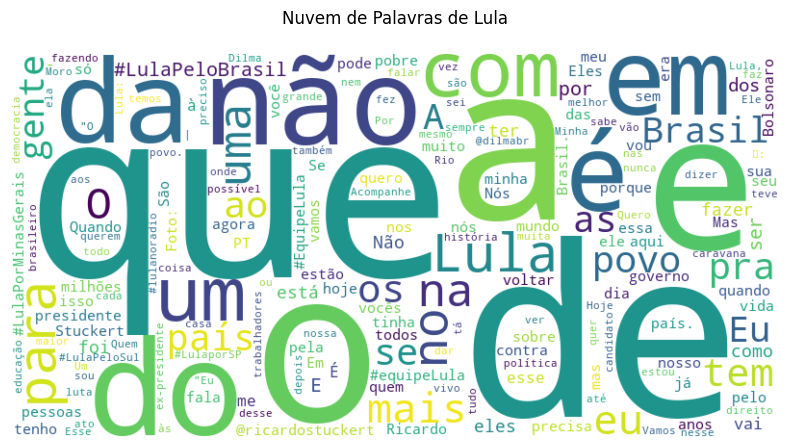

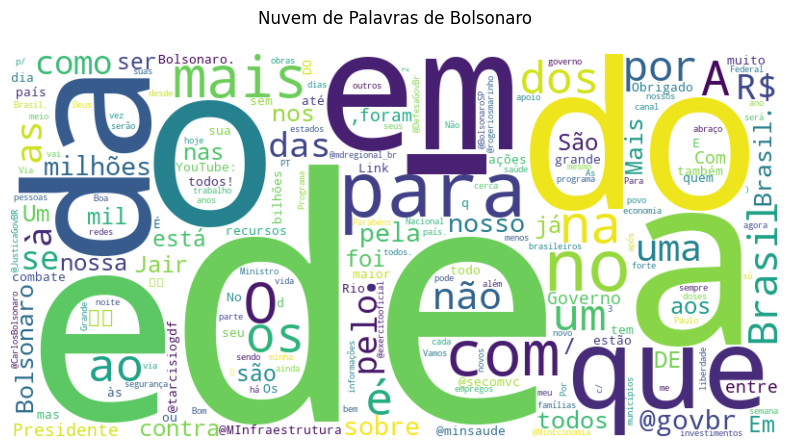

In [89]:
generate_wordcloud_from_df_column(lula_df, 'tweet', 'Lula')
generate_wordcloud_from_df_column(bolsonaro_df, 'tweet', 'Bolsonaro')

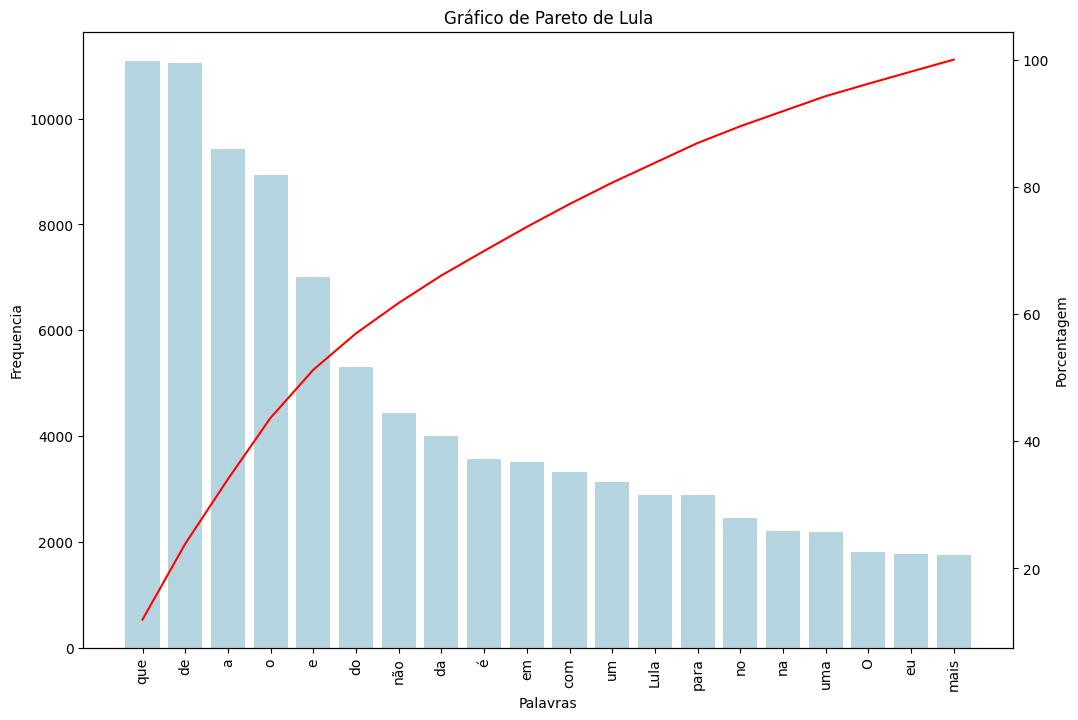

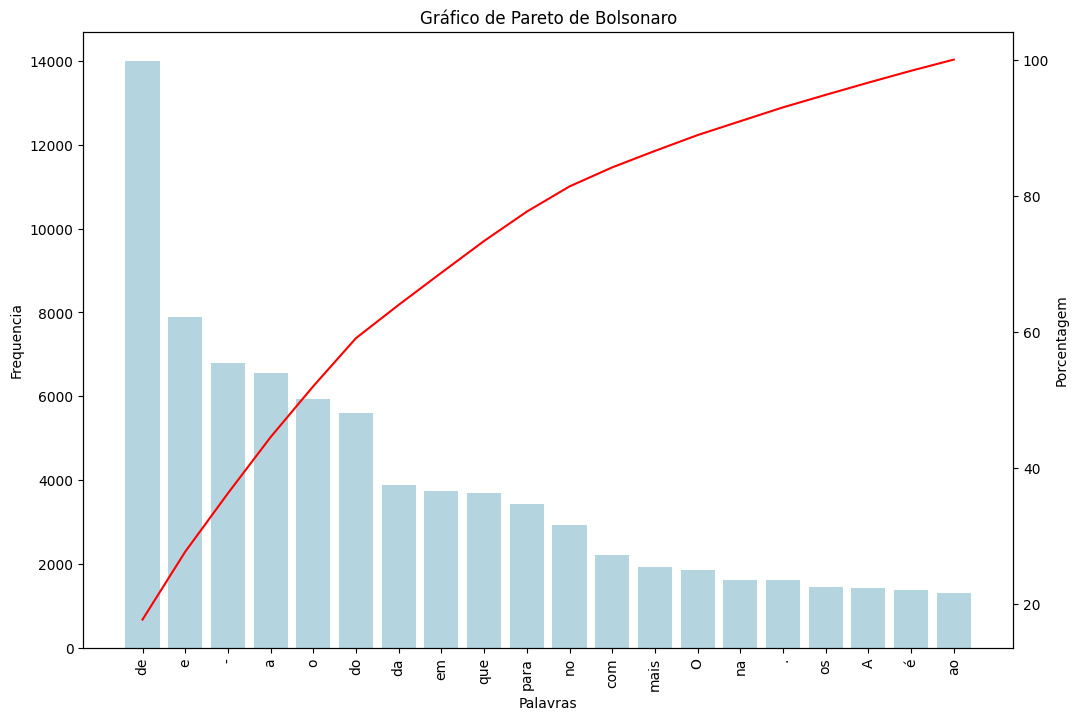

In [90]:
graf_pareto(lula_df, "tweet", 20, 'Lula')
graf_pareto(bolsonaro_df, "tweet", 20, 'Bolsonaro')

In [91]:
lula_df['tweet']

0        O Brasil piorou. A nova pesquisa do boletim De...
1        Nós estamos disputando com alguém que prometeu...
2        As mentiras contra Lula já aconteciam antes me...
3        Aprendi com minha mãe a não desistir. Quando v...
4        "Um dos meus sonhos é um dia estudar medicina....
                               ...                        
15135    "Os trabalhadores estão com @dilmabr ",  diz o...
15136    @dilmabr e Lula saem agora pelas ruas de São B...
15137    Lula visita o @smabc e cumprimenta sindicalist...
15138    Acompanhe notícias da caminhada também pelo @p...
15139    Lula acaba de chegar ao @smabc de onde começar...
Name: tweet, Length: 15140, dtype: object

### Limpeza

Nessa etapa, removeu-se as *stop words*, sendo elas o conjunto pre-setado do corpus do nltk, à exceção de palavras na negativa (que poderiam agregar valor no processamento). Além disso, excluiu-se palavras comuns e sem valor que forma observadas nos tuítes e que escapavam às *stop words*. Excluiu-se também a pontuação e tipos de texto muito utilizados em tuítes: *hashtags*, *cashtags*, *links* e afins. Essas últimas exclusões foram feitas utilizando Regex. Por fim, gerou-se as mesmas visualizações de antes, a fim de destacar as diferenças.

In [256]:
def regex_remove_accents(word):
    """
    Removes common accent characters, lower form.
    Uses: regex.
    Author: https://stackoverflow.com/users/4725707/rigonz

    *w/ small changes for applicability*
    """
    word = re.sub(r'[àáâãäå]', 'a', word)
    word = re.sub(r'[èéêë]', 'e', word)
    word = re.sub(r'[ìíîï]', 'i', word)
    word = re.sub(r'[òóôõö]', 'o', word)
    word = re.sub(r'[ùúûü]', 'u', word)
    word = re.sub(r'[ç]', 'c', word) # addition for this case
    return word

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
                               u"\U0001F680-\U0001F6FF"  # transportes y símbolos mapas
                               u"\U0001F700-\U0001F77F"  # símbolos alquimia
                               u"\U0001F780-\U0001F7FF"  # símbolos marcapáginas
                               u"\U0001F800-\U0001F8FF"  # símbolos y pictogramas suplemento
                               u"\U0001F900-\U0001F9FF"  # emojis diversos
                               u"\U0001FA00-\U0001FA6F"  # emojis adicionales
                               u"\U0001FA70-\U0001FAFF"  # símbolos de juego de cartas
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def regex_filter(texto:str)->str:
    """
    Removes unhelpful types of caracteres or  of string of caracteres, such as
    links, hash e cashtags, mentions, multiple spaces, numbers (here, it wont be useful),
    repeated caracteres and special caracteres.
    Uses: regex.
    Author: Larissa Kelmer
    """
    tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', texto) #removal of links
    tweet = re.sub('\$[a-zA-Z0-9]*', ' ', tweet) #remove cashtags
    tweet = re.sub('\#[a-zA-Z0-9]*', ' ', tweet) #remove hastags
    tweet = re.sub('\@[a-zA-Z0-9]*', ' ', tweet) #remove menções
    tweet = re.sub(r'(\W)\1+', r'\1', tweet) #remove repeated caracteres
    #tweet = re.sub(r'\b\d+(?:\.\d+)?\s+', ' ', tweet) #remove multiples numbers
    #tweet = re.sub(r'(.)\1+', r'\1\1', tweet) #remove repeated caracteres
    tweet = re.sub(r'_', ' ', tweet) #remove underscore
    tweet = re.sub(r'\b[b-df-hj-np-tv-z]\b', '', tweet) #Remove consoantes solitárias
    tweet = re.sub(r'\b\d+\b', '', tweet) # Remove números
    tweet = re.sub(r'\b\.\b', '', tweet)
    tweet = re.sub(r'\b[àáâãäåèéêëìíîïòóôõöùúûü]\b', '', tweet)
    tweet = tweet.strip(string.punctuation) #separating punctuation from words
    tweet = re.sub(r'\t', '', tweet) #remove tab
    tweet = re.sub(r'\s+', ' ', tweet)#remove extra blank spaces

    return tweet

In [257]:
stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words = ([sw.lower() for sw in stop_words if (sw!='não' and sw!='nem')])
print('Stop words: ', stop_words)

#adicionando pontuação nas pontuações a serem removidas
pontuacao = ['),', '",','...','/']
for ponto in punctuation:
  pontuacao.append(ponto)
print('Pontuação: ', punctuation)

#adicionando algumas palavras dos tuítes que não contribuem
extra = ['_br', 'vídeo', 'vai', 'foto', 'Eu', 'a', 'pra', 'Ricardo', 'stuckert'
         'O', '\n', 'então', 'youtube','toda','todo','todas','todos','tambem',
         'ate','sobr','_br', 'aqui', 'fazer', 'casa', 'agora', 'ter', 'sobre',
         'coisa', 'ele', 'precisa', 'preciso', 'hoje', 'quer', 'voce', 'porque', 
         'já', 'lá', 'ao vivo', 'quero', 'pode', 'eu', 'desde', 'via', 'após', 'via',
         'ao', 'vivo', 'r', '   ']
extra = ([word.lower() for word in extra])

stop_words = pontuacao + extra + stop_words
#stop_words = set([regex_remove_accents(texto) for texto in stop_words])
#stop_words_sem_acento = [unidecode.unidecode(texto) for texto in stop_words_final]
print(stop_words)


def remove_stopwords(texto:str)->str:
    if isinstance(texto, str):
        texto = remove_emojis(texto)
        tokens = tokenize.WhitespaceTokenizer().tokenize(texto.lower())
        tokens_sem_stopwords = [regex_filter(word) for word in tokens if word.lower() not in stop_words]
        texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
        return texto_sem_stopwords
    else:
        return texto

Stop words:  ['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvesse

In [258]:
lula_df['tweet'] = lula_df['tweet'].str.lower()
bolsonaro_df['tweet'] = bolsonaro_df['tweet'].str.lower()

lula_df = lula_df.applymap(str)
bolsonaro_df = bolsonaro_df.applymap(str)

lula_df["tratamento_1"] = lula_df["tweet"].apply(remove_stopwords)
bolsonaro_df["tratamento_1"] = bolsonaro_df["tweet"].apply(remove_stopwords)

In [259]:
lula_df['tratamento_1'].replace('', np.nan, inplace=True)
lula_df.dropna(subset=['tratamento_1'], inplace=True)

bolsonaro_df['tratamento_1'].replace('', np.nan, inplace=True)
bolsonaro_df.dropna(subset=['tratamento_1'], inplace=True)

In [260]:
lula_df[['tweet', 'tratamento_1']].head(5)

,tweet,tratamento_1
0,"o brasil piorou. a nova pesquisa do boletim desigualdades nas metrópoles mostra o que já vemos pelas ruas: aumento da miséria, fome e famílias sem um teto pra viver. resultado de um governo que foi irresponsável por quatro anos e agora quer fingir trabalhar. #equipelula",brasil piorou nova pesquisa boletim desigualdades metrópoles mostra vemos ruas aumento miséria fome famílias teto viver resultado governo irresponsável quatro anos fingir trabalhar
1,"nós estamos disputando com alguém que prometeu gerar empregos com uma carteira de trabalho verde e amarela, mas eu quero saber quem é que está trabalhando com a tal da carteira. acabaram com a carteira de trabalho e tiraram o direito dos trabalhadores brasileiros.",disputando alguém prometeu gerar empregos carteira trabalho verde amarela saber trabalhando tal carteira acabaram carteira trabalho tiraram direito trabalhadores brasileiros
2,"as mentiras contra lula já aconteciam antes mesmo de existir o nome fake news. túnel escondido de são bernardo para o morumbi, mansão no guarujá… mesmo com tantas mentiras, lula sempre provou que é inocente. espalhe @verdadenarede. #equipelula https://t.co/iewoqijwvb https://t.co/m98oxdxis9",mentiras contra lula aconteciam antes existir nome fake news túnel escondido bernardo morumbi mansão guarujá… tantas mentiras lula sempre provou inocente espalhe
3,"aprendi com minha mãe a não desistir. quando vocês estiverem desanimados, lembrem de mim. levantem a cabeça e peçam disposição, porque quem não tem disposição não ganha nada. bom dia e boa semana pra nós.",aprendi mãe não desistir desanimados lembrem mim levantem cabeça peçam disposição não disposição não ganha nada bom dia boa semana nós
4,"""um dos meus sonhos é um dia estudar medicina. sei que tenho que estudar muito para ser aprovado no enem ou etc. graças a você, filho de pobre tem chance de entrar em uma universidade. lula você é esperança!"" - yuri, de guaribas, piauí, 13 anos ❤️#equipelula\n\n🎥: @ricardostuckert https://t.co/sddrxoo52w",um sonhos dia estudar medicina sei estudar aprovado enem etc graças você filho pobre chance entrar universidade lula esperança yuri guaribas piauí anos


In [261]:
bolsonaro_df[['tweet', 'tratamento_1']].head(5)

,tweet,tratamento_1
0,"acompanhe, no horário, ao vivo, pelo canal do flow podcast: https://t.co/eztlteqveu https://t.co/mmhjnptc7m",acompanhe horário vivo canal flow podcast
1,- entre os planos aplicados pela atual gestão também está a carteira de desestatização classificada como a maior do mundo.,planos aplicados atual gestão carteira desestatização classificada maior mundo
2,"- recentemente priorizando o saneamento básico e infraestrutura, o bndes anunciou também pareceria com o sebrae para criar um fundo garantidor voltado para empreendedores individuais, além de micros e pequenos empresários.",recentemente priorizando saneamento básico infraestrutura bndes anunciou pareceria sebrae criar fundo garantidor voltado empreendedores individuais além micros pequenos empresários
3,"- longe do pt, bndes que patrocinava obras em ditaduras socialistas deixando de fora investimentos no 🇧🇷 além de outras movimentações sombrias, hoje o órgão recebeu a premiação de “transformação bancária” da américa latina do euromoney awards for excellence em 2022.",longe pt bndes patrocinava obras ditaduras socialistas deixando investimentos além outras movimentações sombrias órgão recebeu premiação “transformação bancária” américa latina euromoney awards excellence
4,"- também, a ampliação do teto do financiamento para o curso de medicina foi aumentado em mais de 20%, em 2022, sendo mais uma novidade aos estudantes da área de saúde.\n \n- implemento de 22,8% passando do atual valor, r$ 42.983,70, para r$ 52.805,66.",também ampliação teto financiamento curso medicina aumentado sendo novidade estudantes área saúde implemento passando atual valor


In [262]:
lula_df['tratamento_1'][10]

' chegaram facebook acompanha lula lá vem curtir compartilhar ajudar conteúdo chegar longe      '

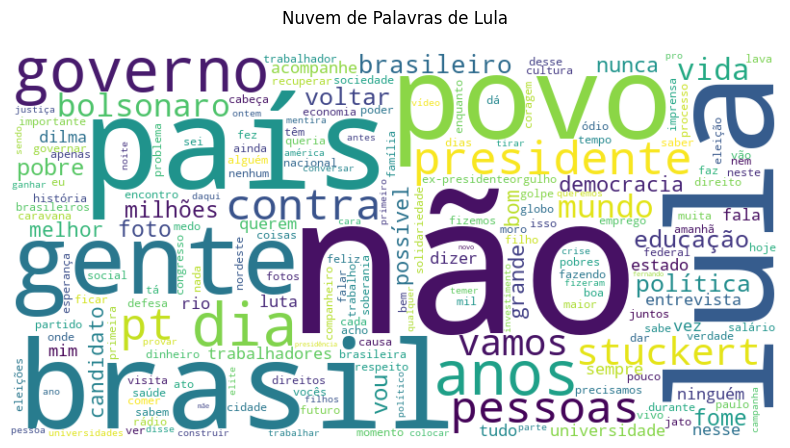

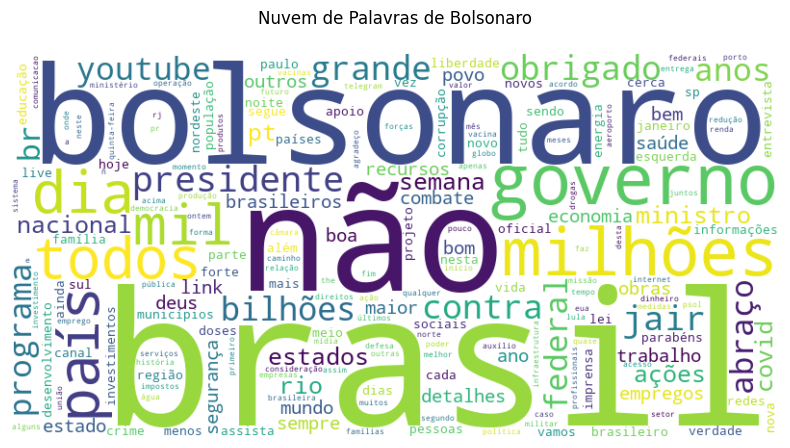

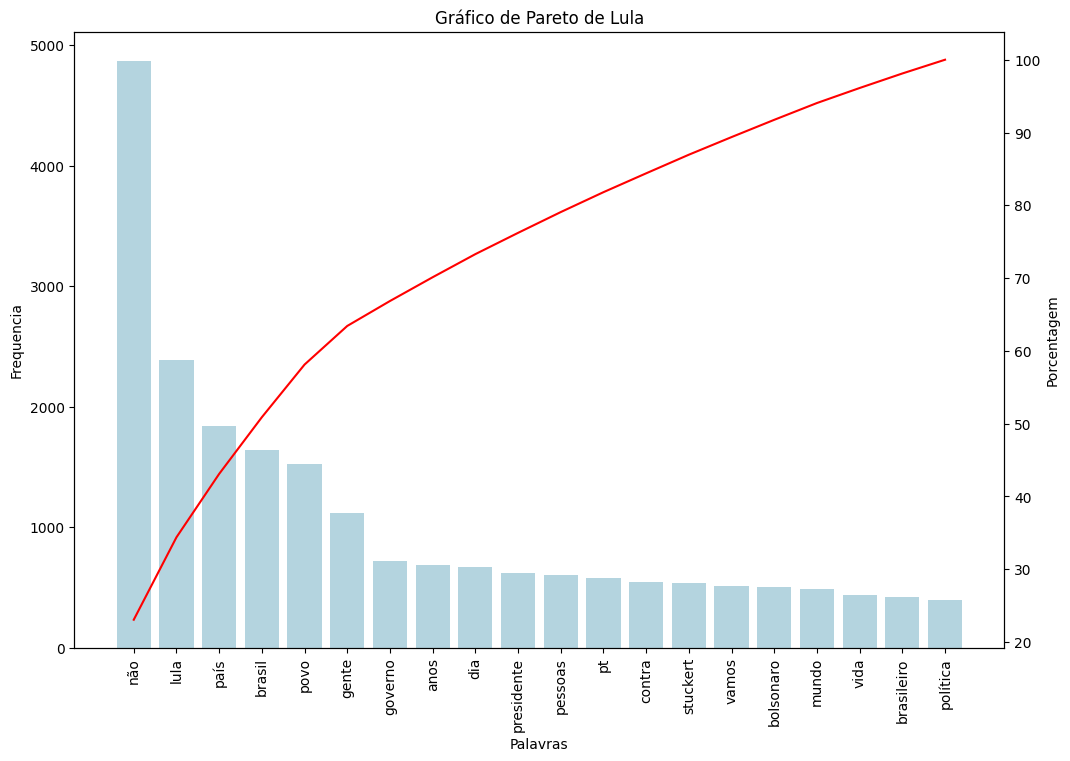

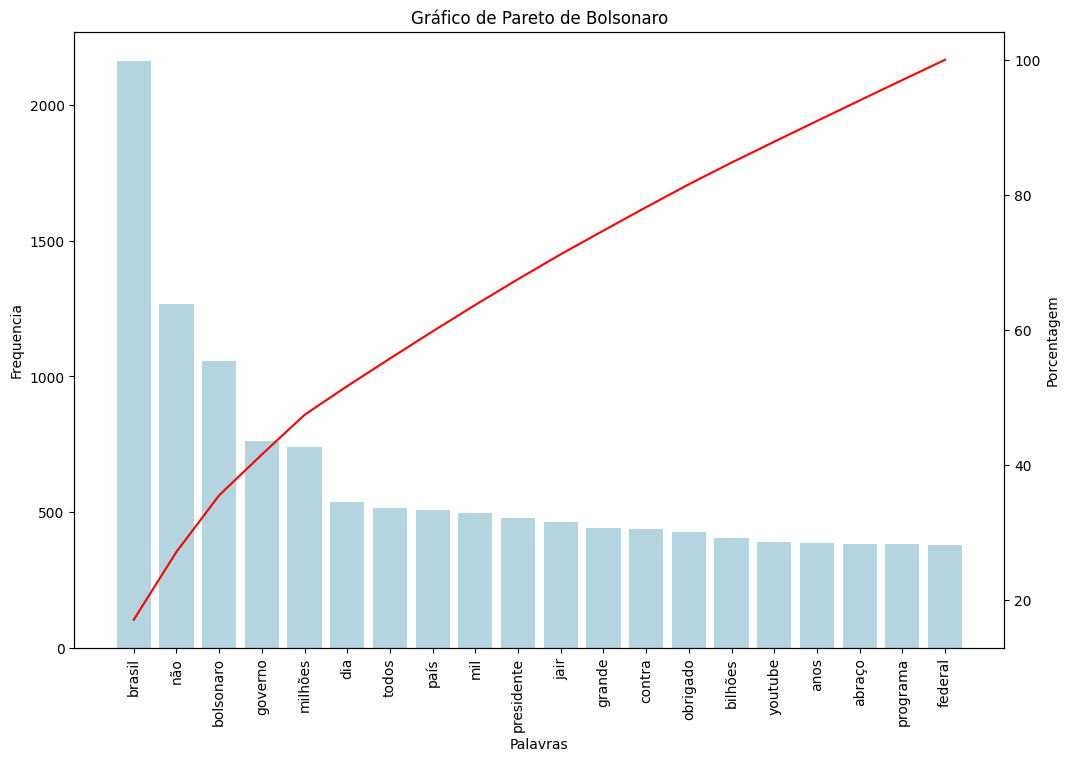

In [263]:
generate_wordcloud_from_df_column(lula_df, 'tratamento_1', 'Lula')
generate_wordcloud_from_df_column(bolsonaro_df, 'tratamento_1', 'Bolsonaro')

graf_pareto(lula_df, "tratamento_1", 20, 'Lula')
graf_pareto(bolsonaro_df, "tratamento_1", 20, 'Bolsonaro')

### Tokenização

 A tokenização é o processo de dividir um texto em unidades menores chamadas tokens. Estes tokens podem ser palavras individuais, subpalavras, caracteres ou até mesmo frases completas, dependendo do objetivo da análise. A tokenização é uma etapa fundamental no pré-processamento de dados em PLN, pois ajuda a transformar o texto em uma forma que possa ser facilmente manipulada e processada por algoritmos de aprendizado de máquina. Essa técnica é crucial em várias tarefas de PLN, como análise de sentimentos, tradução automática, reconhecimento de entidades nomeadas e muito mais, pois fornece a base para a análise textual.

In [272]:
def tokenize_tweet(tweet):
    tokens = re.findall(r"[\w']+", tweet.lower())
    return tokens

bolsonaro_df['tokens'] = bolsonaro_df['tweet'].apply(tokenize_tweet)
lula_df['tokens'] = lula_df['tweet'].apply(tokenize_tweet)

In [273]:
bolsonaro_df[['tweet', 'tokens']].head()

,tweet,tokens
0,"acompanhe, no horário, ao vivo, pelo canal do flow podcast: https://t.co/eztlteqveu https://t.co/mmhjnptc7m","[acompanhe, no, horário, ao, vivo, pelo, canal, do, flow, podcast, https, t, co, eztlteqveu, https, t, co, mmhjnptc7m]"
1,- entre os planos aplicados pela atual gestão também está a carteira de desestatização classificada como a maior do mundo.,"[entre, os, planos, aplicados, pela, atual, gestão, também, está, a, carteira, de, desestatização, classificada, como, a, maior, do, mundo]"
2,"- recentemente priorizando o saneamento básico e infraestrutura, o bndes anunciou também pareceria com o sebrae para criar um fundo garantidor voltado para empreendedores individuais, além de micros e pequenos empresários.","[recentemente, priorizando, o, saneamento, básico, e, infraestrutura, o, bndes, anunciou, também, pareceria, com, o, sebrae, para, criar, um, fundo, garantidor, voltado, para, empreendedores, individuais, além, de, micros, e, pequenos, empresários]"
3,"- longe do pt, bndes que patrocinava obras em ditaduras socialistas deixando de fora investimentos no 🇧🇷 além de outras movimentações sombrias, hoje o órgão recebeu a premiação de “transformação bancária” da américa latina do euromoney awards for excellence em 2022.","[longe, do, pt, bndes, que, patrocinava, obras, em, ditaduras, socialistas, deixando, de, fora, investimentos, no, além, de, outras, movimentações, sombrias, hoje, o, órgão, recebeu, a, premiação, de, transformação, bancária, da, américa, latina, do, euromoney, awards, for, excellence, em, 2022]"
4,"- também, a ampliação do teto do financiamento para o curso de medicina foi aumentado em mais de 20%, em 2022, sendo mais uma novidade aos estudantes da área de saúde.\n \n- implemento de 22,8% passando do atual valor, r$ 42.983,70, para r$ 52.805,66.","[também, a, ampliação, do, teto, do, financiamento, para, o, curso, de, medicina, foi, aumentado, em, mais, de, 20, em, 2022, sendo, mais, uma, novidade, aos, estudantes, da, área, de, saúde, implemento, de, 22, 8, passando, do, atual, valor, r, 42, 983, 70, para, r, 52, 805, 66]"


In [274]:
lula_df[['tweet', 'tokens']].head()

,tweet,tokens
0,"o brasil piorou. a nova pesquisa do boletim desigualdades nas metrópoles mostra o que já vemos pelas ruas: aumento da miséria, fome e famílias sem um teto pra viver. resultado de um governo que foi irresponsável por quatro anos e agora quer fingir trabalhar. #equipelula","[o, brasil, piorou, a, nova, pesquisa, do, boletim, desigualdades, nas, metrópoles, mostra, o, que, já, vemos, pelas, ruas, aumento, da, miséria, fome, e, famílias, sem, um, teto, pra, viver, resultado, de, um, governo, que, foi, irresponsável, por, quatro, anos, e, agora, quer, fingir, trabalhar, equipelula]"
1,"nós estamos disputando com alguém que prometeu gerar empregos com uma carteira de trabalho verde e amarela, mas eu quero saber quem é que está trabalhando com a tal da carteira. acabaram com a carteira de trabalho e tiraram o direito dos trabalhadores brasileiros.","[nós, estamos, disputando, com, alguém, que, prometeu, gerar, empregos, com, uma, carteira, de, trabalho, verde, e, amarela, mas, eu, quero, saber, quem, é, que, está, trabalhando, com, a, tal, da, carteira, acabaram, com, a, carteira, de, trabalho, e, tiraram, o, direito, dos, trabalhadores, brasileiros]"
2,"as mentiras contra lula já aconteciam antes mesmo de existir o nome fake news. túnel escondido de são bernardo para o morumbi, mansão no guarujá… mesmo com tantas mentiras, lula sempre provou que é inocente. espalhe @verdadenarede. #equipelula https://t.co/iewoqijwvb https://t.co/m98oxdxis9","[as, mentiras, contra, lula, já, aconteciam, antes, mesmo, de, existir, o, nome, fake, news, túnel, escondido, de, são, bernardo, para, o, morumbi, mansão, no, guarujá, mesmo, com, tantas, mentiras, lula, sempre, provou, que, é, inocente, espalhe, verdadenarede, equipelula, https, t, co, iewoqijwvb, https, t, co, m98oxdxis9]"
3,"aprendi com minha mãe a não desistir. quando vocês estiverem desanimados, lembrem de mim. levantem a cabeça e peçam disposição, porque quem não tem disposição não ganha nada. bom dia e boa semana pra nós.","[aprendi, com, minha, mãe, a, não, desistir, quando, vocês, estiverem, desanimados, lembrem, de, mim, levantem, a, cabeça, e, peçam, disposição, porque, quem, não, tem, disposição, não, ganha, nada, bom, dia, e, boa, semana, pra, nós]"
4,"""um dos meus sonhos é um dia estudar medicina. sei que tenho que estudar muito para ser aprovado no enem ou etc. graças a você, filho de pobre tem chance de entrar em uma universidade. lula você é esperança!"" - yuri, de guaribas, piauí, 13 anos ❤️#equipelula\n\n🎥: @ricardostuckert https://t.co/sddrxoo52w","[um, dos, meus, sonhos, é, um, dia, estudar, medicina, sei, que, tenho, que, estudar, muito, para, ser, aprovado, no, enem, ou, etc, graças, a, você, filho, de, pobre, tem, chance, de, entrar, em, uma, universidade, lula, você, é, esperança, yuri, de, guaribas, piauí, 13, anos, equipelula, ricardostuckert, https, t, co, sddrxoo52w]"


In [277]:
bolsonaro_df['tokens'] = bolsonaro_df['tratamento_1'].apply(tokenize_tweet)
bolsonaro_df['tokens']

0                                                                                                                                                                                          [acompanhe, horário, vivo, canal, flow, podcast]
1                                                                                                                                                  [planos, aplicados, atual, gestão, carteira, desestatização, classificada, maior, mundo]
2                                  [recentemente, priorizando, saneamento, básico, infraestrutura, bndes, anunciou, pareceria, sebrae, criar, fundo, garantidor, voltado, empreendedores, individuais, além, micros, pequenos, empresários]
3        [longe, pt, bndes, patrocinava, obras, ditaduras, socialistas, deixando, investimentos, além, outras, movimentações, sombrias, órgão, recebeu, premiação, transformação, bancária, américa, latina, euromoney, awards, excellence]
4                                                       

In [278]:
lula_df['tokens'] = lula_df['tratamento_1'].apply(tokenize_tweet)

In [ ]:
lula_df['tweet'] = lula_df['tweet'].str.lower()
bolsonaro_df['tweet'] = bolsonaro_df['tweet'].str.lower()

lula_df = lula_df.applymap(str)
bolsonaro_df = bolsonaro_df.applymap(str)

lula_df["tratamento_1"] = lula_df["tweet"].apply(remove_stopwords)
bolsonaro_df["tratamento_1"] = bolsonaro_df["tweet"].apply(remove_stopwords)

#### N-grams

N-grams são sequências de n itens consecutivos, geralmente palavras, em um texto. Eles capturam informações sobre a estrutura e o contexto do texto, sendo úteis em tarefas de PLN como modelagem de linguagem e extração de características. Ao analisar sequências de palavras, os n-grams ajudam a compreender o contexto e a extrair informações relevantes dos dados textuais.

In [282]:
# Extrair bigramas e trigramas para Bolsonaro
bolsonaro_df['bigrams'] = bolsonaro_df['tokens'].apply(lambda x: list(nltk.bigrams(x)))
bolsonaro_df['trigrams'] = bolsonaro_df['tokens'].apply(lambda x: list(nltk.ngrams(x, 3)))

# Extrair bigramas e trigramas para Lula
lula_df['bigrams'] = lula_df['tokens'].apply(lambda x: list(nltk.bigrams(x)))
lula_df['trigrams'] = lula_df['tokens'].apply(lambda x: list(nltk.ngrams(x, 3)))

# Visualizar os resultados
bolsonaro_df[['tokens', 'bigrams', 'trigrams']].head()
lula_df[['tokens', 'bigrams', 'trigrams']].head()

,tokens,bigrams,trigrams
0,"[brasil, piorou, nova, pesquisa, boletim, desigualdades, metrópoles, mostra, vemos, ruas, aumento, miséria, fome, famílias, teto, viver, resultado, governo, irresponsável, quatro, anos, fingir, trabalhar]","[(brasil, piorou), (piorou, nova), (nova, pesquisa), (pesquisa, boletim), (boletim, desigualdades), (desigualdades, metrópoles), (metrópoles, mostra), (mostra, vemos), (vemos, ruas), (ruas, aumento), (aumento, miséria), (miséria, fome), (fome, famílias), (famílias, teto), (teto, viver), (viver, resultado), (resultado, governo), (governo, irresponsável), (irresponsável, quatro), (quatro, anos), (anos, fingir), (fingir, trabalhar)]","[(brasil, piorou, nova), (piorou, nova, pesquisa), (nova, pesquisa, boletim), (pesquisa, boletim, desigualdades), (boletim, desigualdades, metrópoles), (desigualdades, metrópoles, mostra), (metrópoles, mostra, vemos), (mostra, vemos, ruas), (vemos, ruas, aumento), (ruas, aumento, miséria), (aumento, miséria, fome), (miséria, fome, famílias), (fome, famílias, teto), (famílias, teto, viver), (teto, viver, resultado), (viver, resultado, governo), (resultado, governo, irresponsável), (governo, irresponsável, quatro), (irresponsável, quatro, anos), (quatro, anos, fingir), (anos, fingir, trabalhar)]"
1,"[disputando, alguém, prometeu, gerar, empregos, carteira, trabalho, verde, amarela, saber, trabalhando, tal, carteira, acabaram, carteira, trabalho, tiraram, direito, trabalhadores, brasileiros]","[(disputando, alguém), (alguém, prometeu), (prometeu, gerar), (gerar, empregos), (empregos, carteira), (carteira, trabalho), (trabalho, verde), (verde, amarela), (amarela, saber), (saber, trabalhando), (trabalhando, tal), (tal, carteira), (carteira, acabaram), (acabaram, carteira), (carteira, trabalho), (trabalho, tiraram), (tiraram, direito), (direito, trabalhadores), (trabalhadores, brasileiros)]","[(disputando, alguém, prometeu), (alguém, prometeu, gerar), (prometeu, gerar, empregos), (gerar, empregos, carteira), (empregos, carteira, trabalho), (carteira, trabalho, verde), (trabalho, verde, amarela), (verde, amarela, saber), (amarela, saber, trabalhando), (saber, trabalhando, tal), (trabalhando, tal, carteira), (tal, carteira, acabaram), (carteira, acabaram, carteira), (acabaram, carteira, trabalho), (carteira, trabalho, tiraram), (trabalho, tiraram, direito), (tiraram, direito, trabalhadores), (direito, trabalhadores, brasileiros)]"
2,"[mentiras, contra, lula, aconteciam, antes, existir, nome, fake, news, túnel, escondido, bernardo, morumbi, mansão, guarujá, tantas, mentiras, lula, sempre, provou, inocente, espalhe]","[(mentiras, contra), (contra, lula), (lula, aconteciam), (aconteciam, antes), (antes, existir), (existir, nome), (nome, fake), (fake, news), (news, túnel), (túnel, escondido), (escondido, bernardo), (bernardo, morumbi), (morumbi, mansão), (mansão, guarujá), (guarujá, tantas), (tantas, mentiras), (mentiras, lula), (lula, sempre), (sempre, provou), (provou, inocente), (inocente, espalhe)]","[(mentiras, contra, lula), (contra, lula, aconteciam), (lula, aconteciam, antes), (aconteciam, antes, existir), (antes, existir, nome), (existir, nome, fake), (nome, fake, news), (fake, news, túnel), (news, túnel, escondido), (túnel, escondido, bernardo), (escondido, bernardo, morumbi), (bernardo, morumbi, mansão), (morumbi, mansão, guarujá), (mansão, guarujá, tantas), (guarujá, tantas, mentiras), (tantas, mentiras, lula), (mentiras, lula, sempre), (lula, sempre, provou), (sempre, provou, inocente), (provou, inocente, espalhe)]"
3,"[aprendi, mãe, não, desistir, desanimados, lembrem, mim, levantem, cabeça, peçam, disposição, não, disposição, não, ganha, nada, bom, dia, boa, semana, nós]","[(aprendi, mãe), (mãe, não), (não, desistir), (desistir, desanimados), (desanimados, lembrem), (lembrem, mim), (mim, levantem), (levantem, cabeça), (cabeça, peçam), (peçam, disposição), (disposição, não), (não, disposição), (disposição, não), (não, ganha), (ganha, nada), (nada, bom), (bom, dia), (

In [292]:
def graf_pareto_n_grams(texto, coluna_texto, quantidade, nome):

    todos_ngramas = [' '.join(ngram) for ngrams_list in texto[coluna_texto] for ngram in ngrams_list]

    # Calcular as frequências dos n-gramas
    frequencias = nltk.FreqDist(todos_ngramas)

    # Criar um DataFrame com as frequências dos n-gramas
    df_frequencias = pd.DataFrame({'N-gramas': frequencias.keys(),
                                   'Frequência': frequencias.values()})

    # Selecionar os n-gramas mais frequentes
    df_frequencias = df_frequencias.nlargest(n=quantidade, columns='Frequência')

    # Calcular a porcentagem acumulada
    total = df_frequencias['Frequência'].sum()
    df_frequencias['Porcentagem'] = (df_frequencias['Frequência'].cumsum() / total) * 100

    # Plotar o gráfico de Pareto
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_frequencias, x='N-gramas', y='Frequência', color='lightblue')
    ax2 = ax.twinx()
    sns.lineplot(data=df_frequencias, x='N-gramas', y='Porcentagem', color='red', sort=False, ax=ax2)
    plt.title('Gráfico de Pareto de ' + nome)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

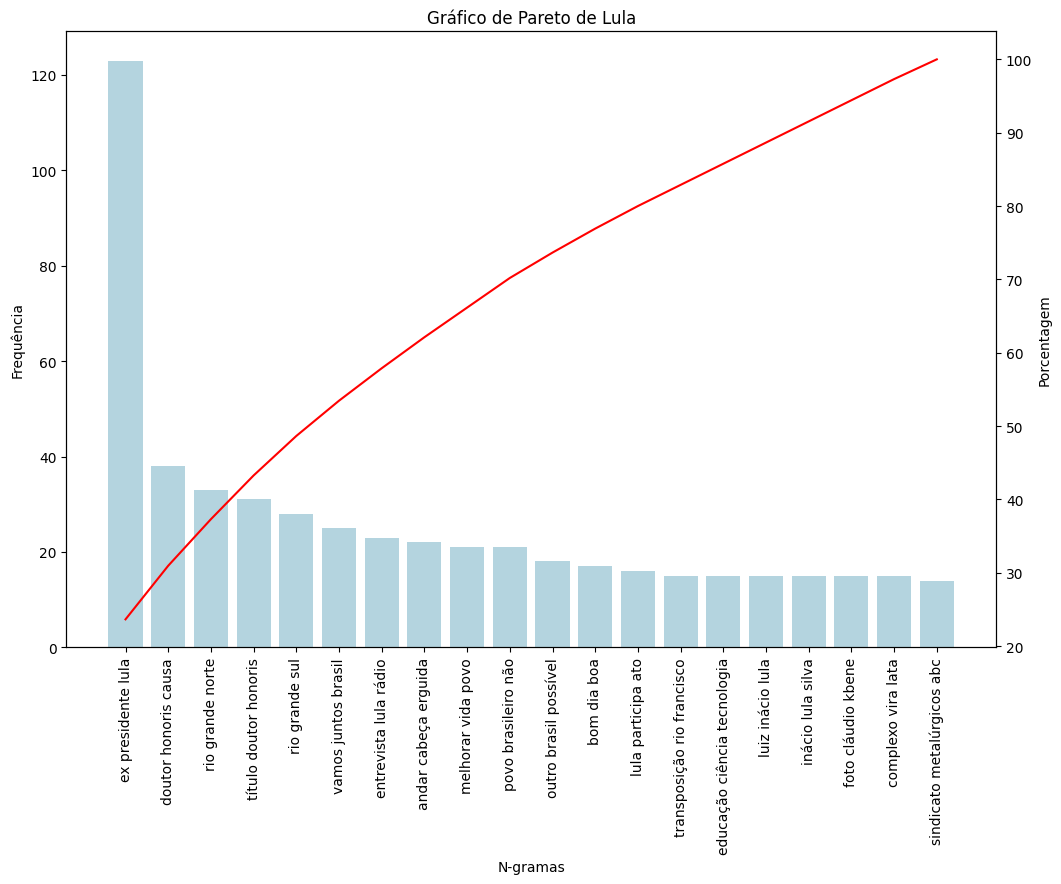

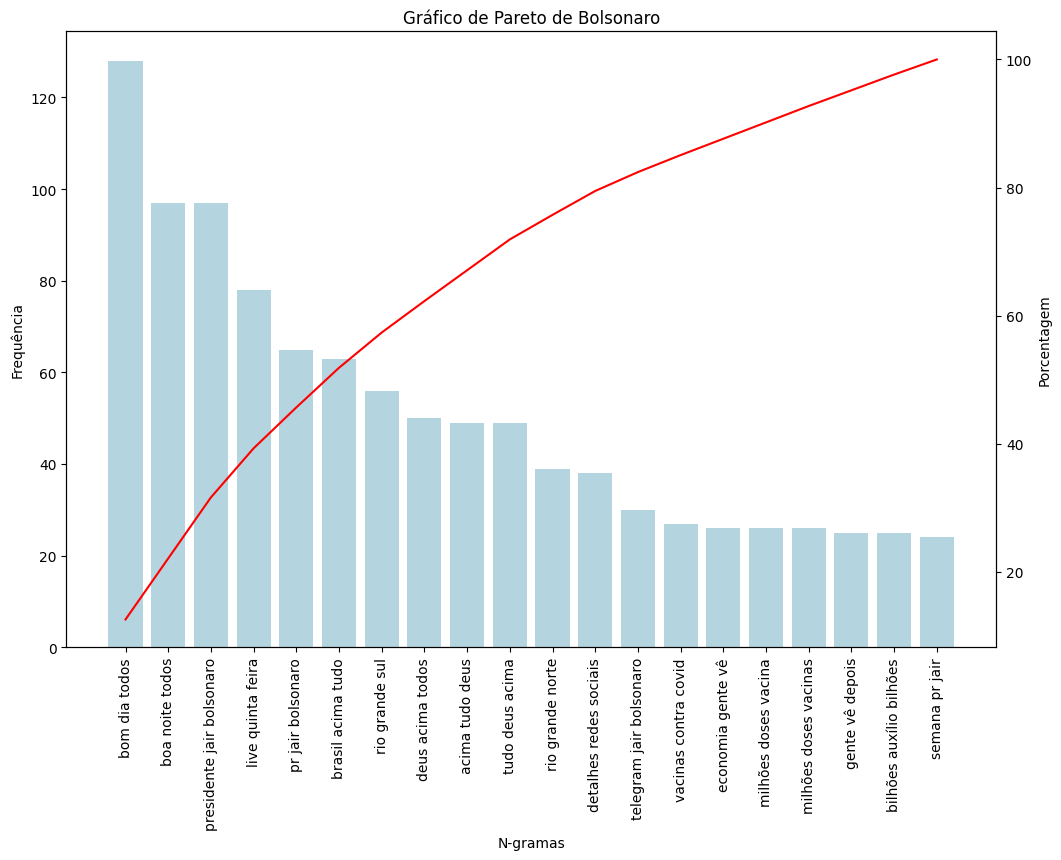

In [293]:
graf_pareto_n_grams(lula_df, 'trigrams', 20, 'Lula')
graf_pareto_n_grams(bolsonaro_df, 'trigrams', 20, 'Bolsonaro')

### Feature Extraction

Feature extraction é o processo de transformar dados em representações numéricas que capturam informações de maior relevância. Ele permite processar e tirar *insights* de modelos complexos.

#### Embeddings

Embeddings são representações vetoriais de palavras e permitem a transformação dessas palavras para formatos numéricos que capturam a semântica do texto. O Spacy usa uma CNN para esse cálculo por *default*. É de interesse usar o BERT numa próxima etapa. 

In [294]:
def generate_embeddings(tokens):
    embeddings = []
    for token in tokens:
        embedding = nlp(token).vector
        embeddings.append(embedding)
    return embeddings

lula_df["embeddings_uni"] = lula_df['tokens'].apply(lambda x: generate_embeddings(x))
bolsonaro_df["embeddings_uni"] = bolsonaro_df['tokens'].apply(lambda x: generate_embeddings(x))

In [295]:
lula_df["embeddings_uni"]

0              [[0.94597495, -1.4509016, -0.7242687, -2.5647259, 1.6869419, -4.6141977, -0.25251797, -1.3752345, -5.2429066, -0.026394606, 1.4919624, -3.007764, -3.0420983, 0.5825694, -1.3168366, 1.8034259, 8.100355, 2.8696377, -3.8086133, -0.16515902, -0.57154626, 0.046026647, -3.233074, -2.4109745, 2.409361, 0.85668576, 1.7981569, -1.5379915, 2.404906, -3.0185142, 5.155394, -1.1705754, -2.0493333, 1.7879345, 3.9366999, 2.477941, -3.6461577, 6.102936, -1.288666, 1.1050164, -3.0956204, -3.786377, -3.7822561, -2.9995127, -2.6431947, -3.3033419, -2.6022453, -0.116508305, 0.6607145, 0.6449104, -4.1910353, 0.63138604, -1.65208, 3.9032502, -1.1970754, 1.0111655, 3.643776, -4.7509503, -3.0533512, 4.0299306, -3.7594702, 6.136184, -1.7213638, -0.58831465, 0.74594545, -2.136914, -1.8694478, 5.0960784, -3.7284198, 2.3691633, 0.76465213, -0.03270054, 6.9174795, 0.18335101, -0.68457454, 6.0676246, -0.9809929, 8.259279, -1.6937317, -1.5724638, -1.706291, 0.053837597, 2.3204384, 2.900614, -3.6790578

In [296]:
bolsonaro_df["embeddings_uni"]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
def get_bigram_embeddings(bigrams):
    embeddings = []
    for bigram in bigrams:
        if isinstance(bigram, tuple):
            bigram_str = ' '.join(bigram)
            tokens = nlp(bigram_str)
            if len(tokens) == 2:
                embedding = np.mean([token.vector for token in tokens], axis=0)
                embeddings.append(embedding)
    return embeddings


lula_df["embeddings"] = lula_df['bigrams'].apply(lambda x: get_bigram_embeddings(x))
bolsonaro_df["embeddings"] = bolsonaro_df['bigrams'].apply(lambda x: get_bigram_embeddings(x))

In [287]:
lula_df["embeddings"]

0                              [[-0.9532685, 1.8346896, -1.6068605, -1.5928378, -2.0871203, -1.9175644, 0.8824487, 0.527623, -1.507092, -0.1747185, 3.1382926, -1.5302312, -3.5262408, -0.46770692, -2.9872427, 0.15003407, 4.0942006, 5.151145, -2.116745, -1.7274919, -2.8302608, -1.2060572, -1.0191576, 1.2832198, -0.61039186, 0.9421127, 2.7422476, 1.5352337, 0.91025263, 1.964893, -1.476445, 0.009442225, -0.6001667, -0.61754096, 1.7491933, 1.1512958, -4.451543, 0.83882785, -2.4633017, -0.5958812, 1.1428708, -1.6415503, -1.1153834, -1.1737335, -0.5477996, -3.5181448, 1.0111573, 0.15958956, -1.5286623, -1.0707352, -1.626778, -0.7270168, 0.7998677, 2.8176303, 1.5773901, -1.4892603, -0.45971394, -2.3636255, -2.596085, 1.1583316, 0.51423824, 5.1765985, -0.10155791, -1.0217881, 2.1606996, 2.534383, -0.7045529, 4.3148518, -0.45008445, -1.855949, 7.7264695, -1.1892319, 2.6816304, 0.75519216, -0.15984035, 3.8182228, 0.49949622, 3.4371114, -1.542817, -2.284036, -3.1122983, 1.4038908, 3.2042086, -0.44

In [288]:
bolsonaro_df["embeddings"] 

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       